In [1]:
# 단계 1: 폰트 설치
import matplotlib.font_manager as fm

!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

In [ ]:
# 단계 2: 런타임 재시작
import os
os.kill(os.getpid(), 9)

In [ ]:
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

#레티나 디스플레이로 폰트가 선명하게 표시되도록 합니다.
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()

from sklearn import model_selection
from sklearn import metrics, ensemble, linear_model
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore') 

## Load Dataset

In [5]:
!pip install kaggle 
from google.colab import files 
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"minaahayley","key":"2b9a4ddc90c33aadf0ac55ad9e6919df"}'}

In [6]:
!mkdir -p ~/.kaggle #create folder name Kaggle
!cp kaggle.json ~/.kaggle #copy kaggle.jason into folder Kaggle
!chmod 600 ~/.kaggle/kaggle.json #ignore Permission Warning 

%ls ~/.kaggle

kaggle.json


In [7]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting

!unzip walmart-recruiting-store-sales-forecasting.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 160MB/s]
Archive:  walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [8]:
!unzip features.csv.zip    
!unzip sampleSubmission.csv.zip  
!unzip test.csv.zip
!unzip train.csv.zip

Archive:  features.csv.zip
  inflating: features.csv            
Archive:  sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  train.csv.zip
  inflating: train.csv               


In [3]:
!mkdir -p ~/.kaggle/competitions/walmart-recruiting-store-sales-forecasting #create folder name Kaggle
!cp features.csv ~/.kaggle/competitions/walmart-recruiting-store-sales-forecasting #copy into folder Kaggle 
!cp sampleSubmission.csv  ~/.kaggle/competitions/walmart-recruiting-store-sales-forecasting
!cp stores.csv  ~/.kaggle/competitions/walmart-recruiting-store-sales-forecasting
!cp test.csv  ~/.kaggle/competitions/walmart-recruiting-store-sales-forecasting
!cp train.csv  ~/.kaggle/competitions/walmart-recruiting-store-sales-forecasting

%ls ~/.kaggle/competitions/walmart-recruiting-store-sales-forecasting

features.csv  sampleSubmission.csv  stores.csv  test.csv  train.csv


## Data loading 

In [3]:
features = pd.read_csv('~/.kaggle/competitions/walmart-recruiting-store-sales-forecasting/features.csv')
train = pd.read_csv('~/.kaggle/competitions/walmart-recruiting-store-sales-forecasting/train.csv')
stores = pd.read_csv('~/.kaggle/competitions/walmart-recruiting-store-sales-forecasting/stores.csv')
test = pd.read_csv('~/.kaggle/competitions/walmart-recruiting-store-sales-forecasting/test.csv')
sample_submission = pd.read_csv('~/.kaggle/competitions/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv')

In [4]:
feature_store = features.merge(stores, on='Store', how='inner')
train_df = train.merge(feature_store, on=['Store', 'Date', 'IsHoliday'], how='left')
train_df = train_df.reset_index(drop=True)

test_df = test.merge(feature_store, on=['Store', 'Date', 'IsHoliday'], how='left')
test_df = test_df.reset_index(drop=True)

In [5]:
print(train_df.shape)
print(test_df.shape)

(421570, 16)
(115064, 15)


## EDA 

In [6]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,421570.0,22.200546,12.785297,1.000,11.000000,22.00000,33.000000,45.000000
Dept,421570.0,44.260317,30.492054,1.000,18.000000,37.00000,74.000000,99.000000
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.940,2079.650000,7612.03000,20205.852500,693099.360000
Temperature,421570.0,60.090059,18.447931,-2.060,46.680000,62.09000,74.280000,100.140000
Fuel_Price,421570.0,3.361027,0.458515,2.472,2.933000,3.45200,3.738000,4.468000
MarkDown1,150681.0,7246.420196,8291.221345,0.270,2240.270000,5347.45000,9210.900000,88646.760000
MarkDown2,111248.0,3334.628621,9475.357325,-265.760,41.600000,192.00000,1926.940000,104519.540000
MarkDown3,137091.0,1439.421384,9623.078290,-29.100,5.080000,24.60000,103.990000,141630.610000
MarkDown4,134967.0,3383.168256,6292.384031,0.220,504.220000,1481.31000,3595.040000,67474.850000
MarkDown5,151432.0,4628.975079,5962.887455,135.160,1878.440000,3359.45000,5563.800000,108519.280000


In [7]:
# Converting date column to datetime 
feature_store['Date'] = pd.to_datetime(feature_store['Date'])
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# Adding some basic datetime features 
feature_store['Day'] = feature_store['Date'].dt.day 
feature_store['Week'] = feature_store['Date'].dt.week
feature_store['Month'] = feature_store['Date'].dt.month
feature_store['Year'] = feature_store['Date'].dt.year

In [8]:
train.sample()

,Store,Dept,Date,Weekly_Sales,IsHoliday
268344,28,10,2011-07-29,21958.36,False


In [9]:
feature_store.sample()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size,Day,Week,Month,Year
5583,31,2012-06-15,81.51,3.393,7348.68,NaN,2.85,2541.21,5428.08,221.40099,6.891,False,A,203750,15,24,6,2012


In [10]:
train_df = train.merge(feature_store, how='left', on=['Store', 'Date', 'IsHoliday']).reset_index(drop=True)
test_df = test.merge(feature_store, how='left', on=['Store', 'Date', 'IsHoliday']).reset_index(drop=True)

In [11]:
df_weeks = train_df.groupby('Week').sum()

Text(0.5, 1.0, 'Sales over weeks')

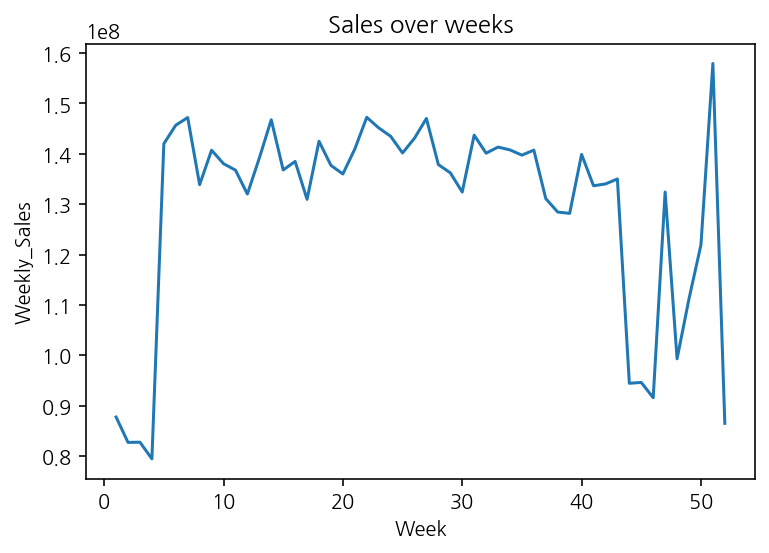

In [12]:
sns.lineplot(data=df_weeks, x=df_weeks.index, y='Weekly_Sales')
plt.title('Sales over weeks')

* 매출은 상당히 안정적이지만, 42주차에 급락하고, 다시 반등하는 모습올 보인다. 

### Markdowns relationship with sales 

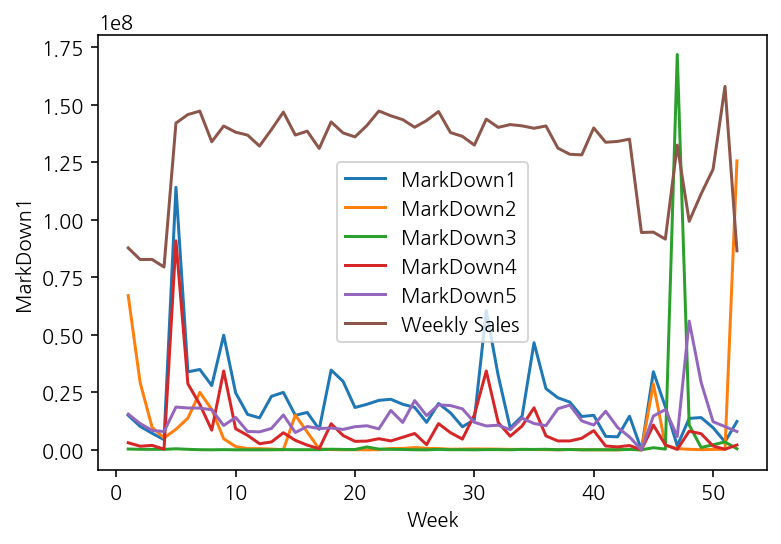

In [13]:
sns.lineplot(x = df_weeks.index, y=df_weeks['MarkDown1'], label='MarkDown1')
sns.lineplot(x = df_weeks.index, y=df_weeks['MarkDown2'], label='MarkDown2')
sns.lineplot(x = df_weeks.index, y=df_weeks['MarkDown3'], label='MarkDown3')
sns.lineplot(x = df_weeks.index, y=df_weeks['MarkDown4'], label='MarkDown4')
sns.lineplot(x = df_weeks.index, y=df_weeks['MarkDown5'], label='MarkDown5')
sns.lineplot(data=df_weeks, x=df_weeks.index, y='Weekly_Sales', label='Weekly Sales') 

### Mean sales across the years 

In [14]:
weekly_sales = train_df.groupby(['Year', 'Week'], as_index=False).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2010 = train_df.loc[train_df['Year']==2010].groupby('Week').agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2011 = train_df.loc[train_df['Year']==2011].groupby('Week').agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2012 = train_df.loc[train_df['Year']==2012].groupby('Week').agg({'Weekly_Sales': ['mean', 'median']})

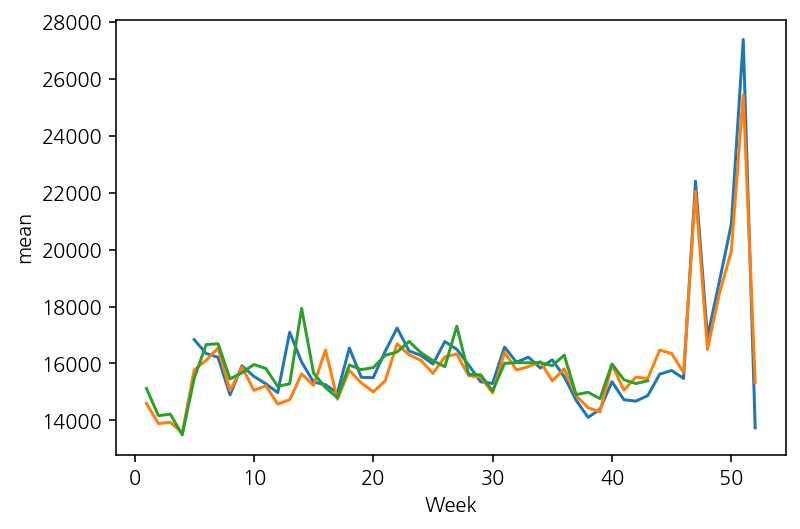

In [15]:
sns.lineplot(data=weekly_sales2010, x=weekly_sales2010['Weekly_Sales']['mean'].index, y=weekly_sales2010['Weekly_Sales']['mean'])
sns.lineplot(data=weekly_sales2011, x=weekly_sales2011['Weekly_Sales']['mean'].index, y=weekly_sales2011['Weekly_Sales']['mean'])
sns.lineplot(data=weekly_sales2012, x=weekly_sales2012['Weekly_Sales']['mean'].index, y=weekly_sales2012['Weekly_Sales']['mean'])

* 47주차 Thanksgiving, 51주차 Christmas를 기점으로 주차별 평균 매출이 크게 상승하였다. 
* 2개의 공휴일이 매출에 크게 기여하는 변수이다. 

### Other features analysis 

In [16]:
# Converting the temperature to celsius for a better interpretation
train_df['Temperature'] = train_df['Temperature'].apply(lambda x : (x-32)/1.8)
test_df['Temperature'] = test_df['Temperature'].apply(lambda x : (x-32)/1.8)

In [17]:
train_plt = train_df.sample(frac=0.20)

In [18]:
print(train_df.shape)
print(train_plt.shape)

(421570, 20)
(84314, 20)


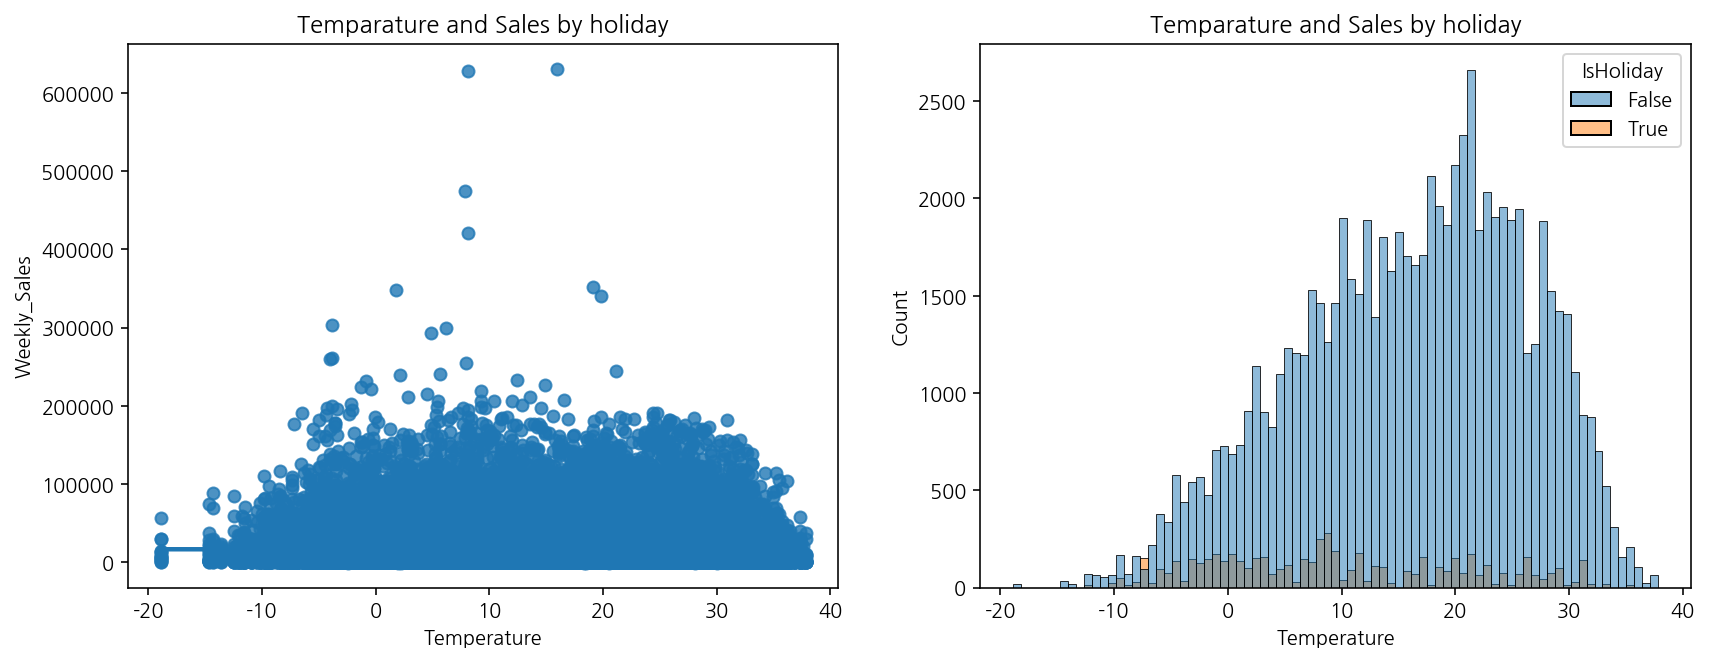

In [19]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(1, 2, 1) # 서브플롯들을 2 x 1 배열로 배치 그중 첫번째
ax2 = fig.add_subplot(1, 2, 2)  # 서브플롯들을 2 x 1 배열로 배치 그중 두번째

# Temperature
sns.regplot(data=train_plt, x='Temperature', y='Weekly_Sales', ax=ax1) 
ax1.set_title('Temparature and Sales by holiday')

sns.histplot(data=train_plt, x='Temperature', hue='IsHoliday', ax=ax2) 
ax2.set_title('Temparature and Sales by holiday')

plt.show();

* 영하에서 영상으로 올라갈수록 매출이 상승한다. 

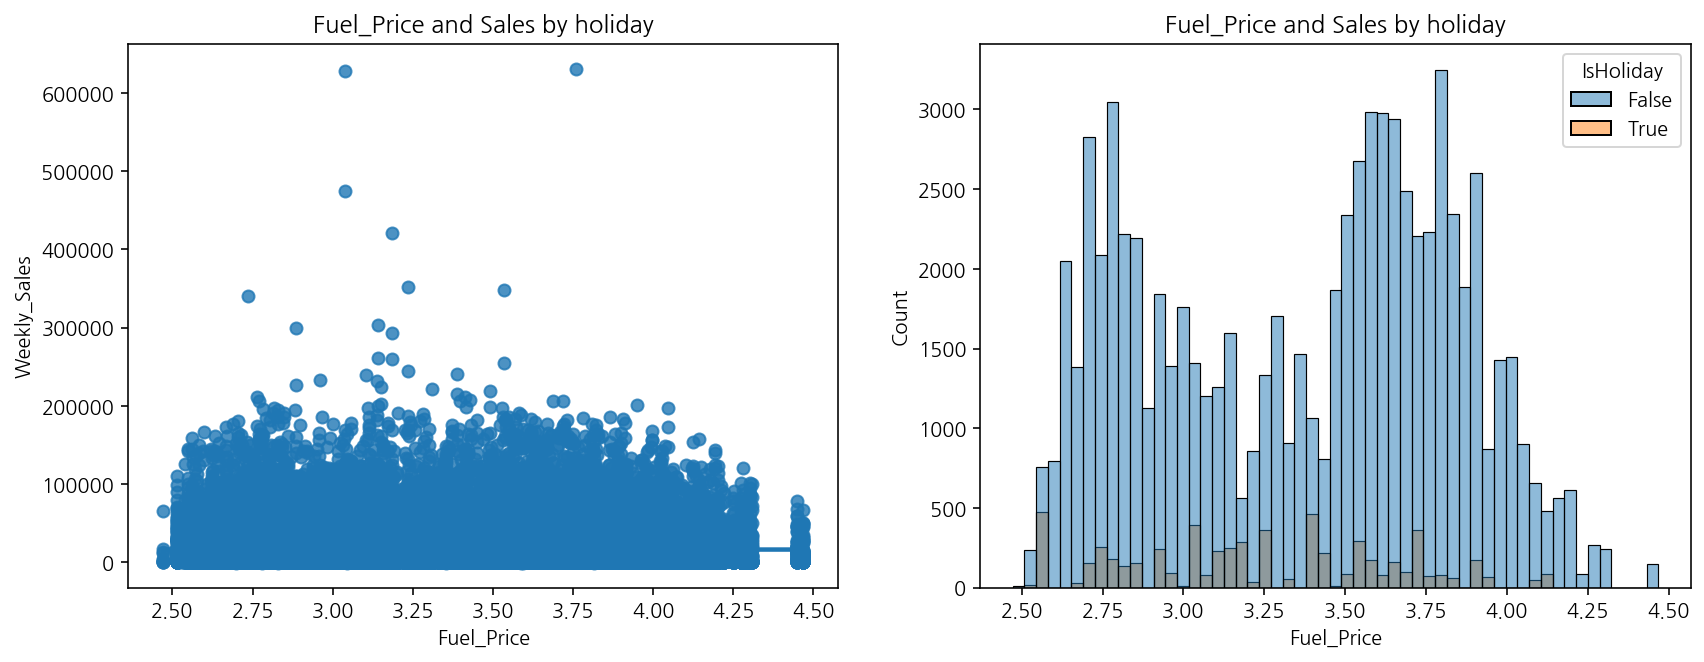

In [20]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(1, 2, 1) # 서브플롯들을 2 x 1 배열로 배치 그중 첫번째
ax2 = fig.add_subplot(1, 2, 2)  # 서브플롯들을 2 x 1 배열로 배치 그중 두번째

# Fuel_Price
sns.regplot(data=train_plt, x='Fuel_Price', y='Weekly_Sales', ax=ax1) 
ax1.set_title('Fuel_Price and Sales by holiday')

sns.histplot(data=train_plt, x='Fuel_Price', hue='IsHoliday', ax=ax2) 
ax2.set_title('Fuel_Price and Sales by holiday')

plt.show();

* 연료와 매출액은 무관해 보인다. 


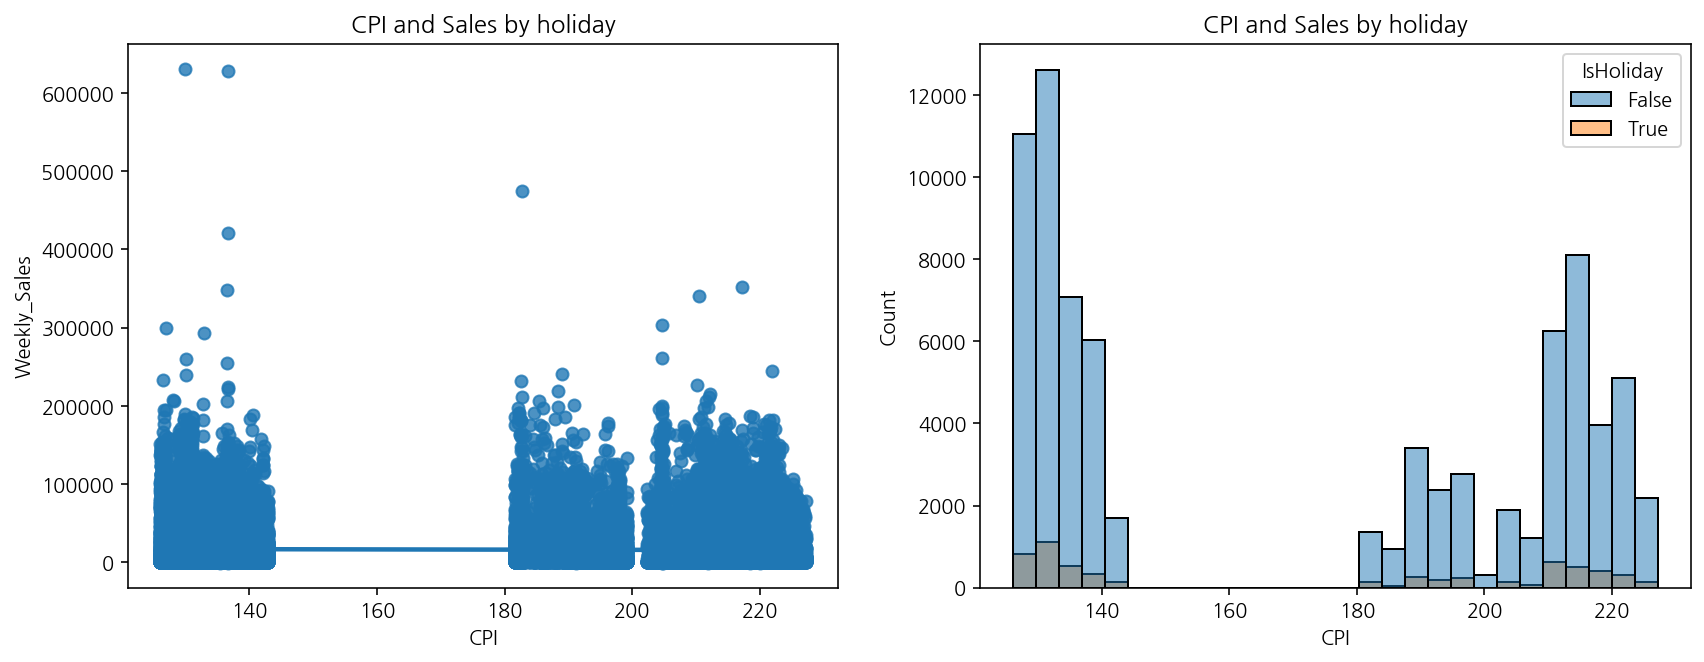

In [21]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(1, 2, 1) # 서브플롯들을 2 x 1 배열로 배치 그중 첫번째
ax2 = fig.add_subplot(1, 2, 2)  # 서브플롯들을 2 x 1 배열로 배치 그중 두번째

# CPI
sns.regplot(data=train_plt, x='CPI', y='Weekly_Sales', ax=ax1) 
ax1.set_title('CPI and Sales by holiday')

sns.histplot(data=train_plt, x='CPI', hue='IsHoliday', ax=ax2) 
ax2.set_title('CPI and Sales by holiday')

plt.show();

* 크게 세 그룹으로 나뉘는 것 같다. 소비자 물가 지수와 매출액은 무관해 보인다. 

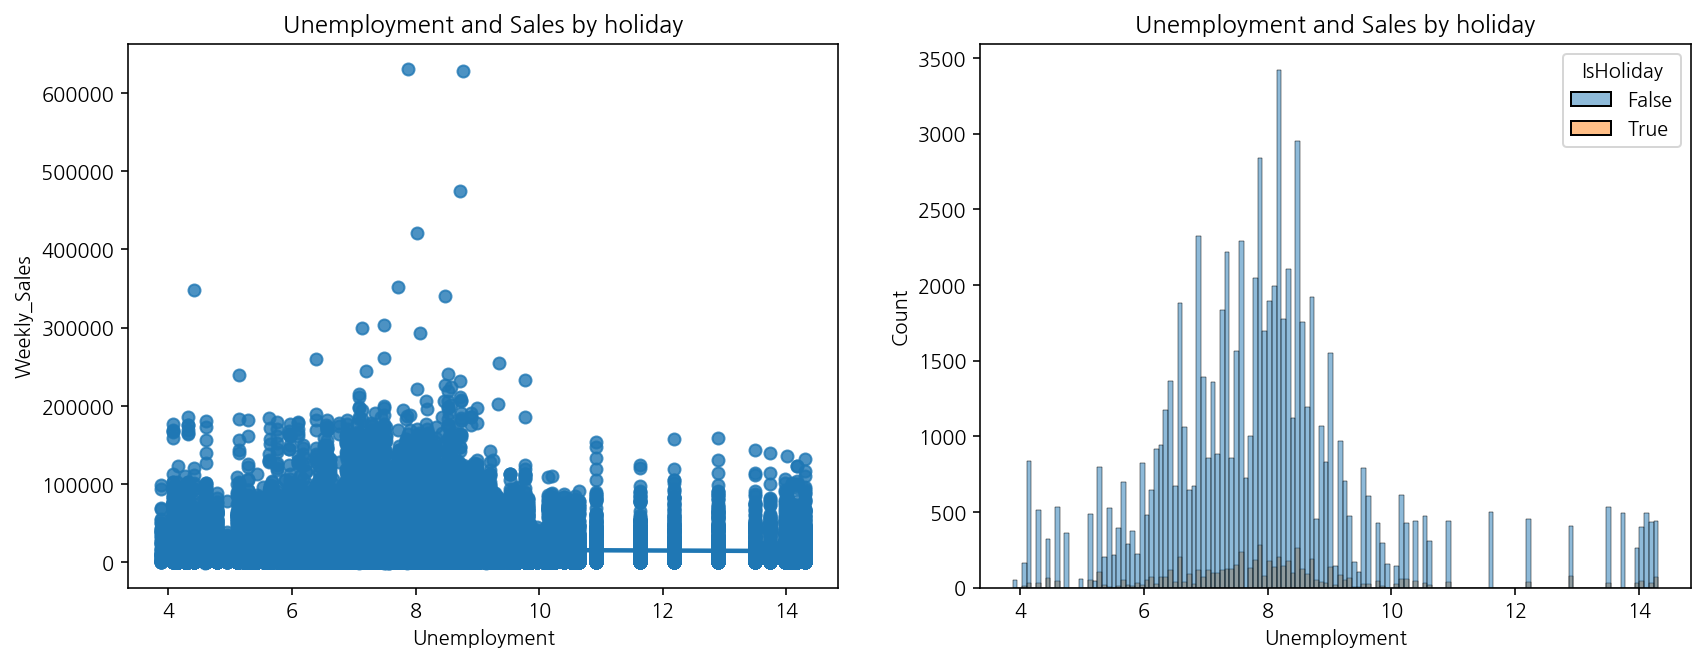

In [22]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(1, 2, 1) # 서브플롯들을 2 x 1 배열로 배치 그중 첫번째
ax2 = fig.add_subplot(1, 2, 2)  # 서브플롯들을 2 x 1 배열로 배치 그중 두번째

# Unemployment
sns.regplot(data=train_plt, x='Unemployment', y='Weekly_Sales', ax=ax1) 
ax1.set_title('Unemployment and Sales by holiday')

sns.histplot(data=train_plt, x='Unemployment', hue='IsHoliday', ax=ax2) 
ax2.set_title('Unemployment and Sales by holiday')

plt.show();

* 실업률과 매출액은 무관해 보인다. 

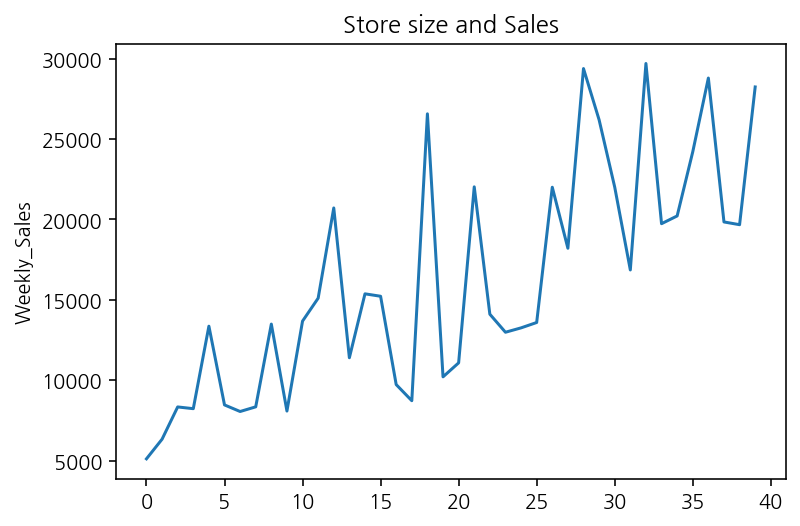

In [23]:
sizes = train_plt.groupby('Size')['Weekly_Sales'].mean().reset_index()

sns.lineplot(data=sizes, x=sizes.index, y=sizes.Weekly_Sales) 
plt.title('Store size and Sales');

* Store Size가 클수록 평균 매출액은 상승한다. 가장 연관성이 높은 피쳐이다. 

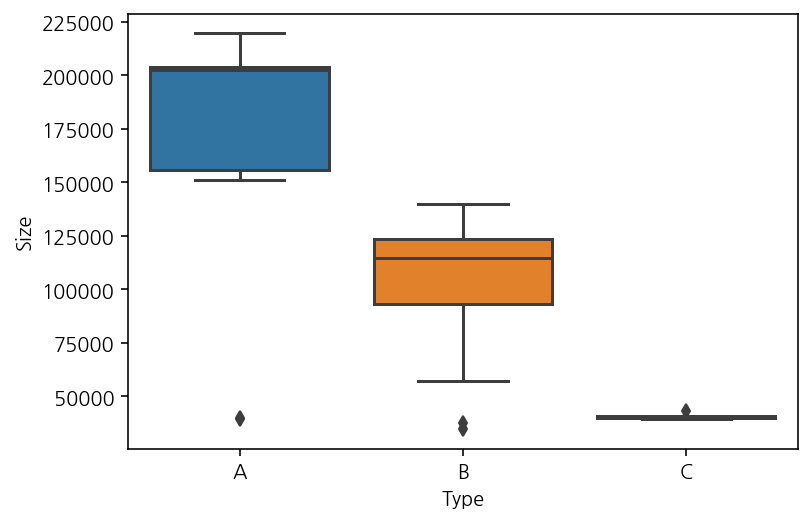

In [24]:
store_type = stores[['Type', 'Size']]
sns.boxplot(data=store_type, x='Type', y='Size')

* A 타입이 매장 규모가 가장 크다. Store type은 Size에 영향을 주는 요소이다. 

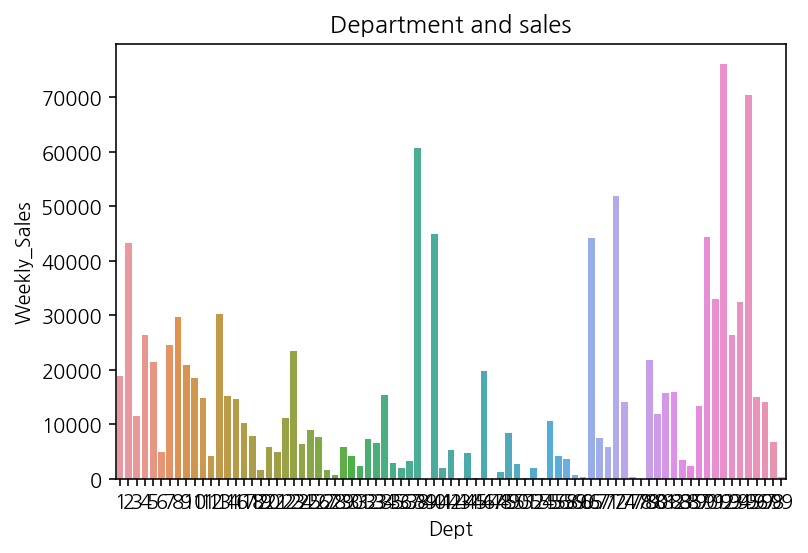

In [25]:
dept = train_plt.groupby('Dept')['Weekly_Sales'].mean().reset_index() 

sns.barplot(data=dept, x='Dept', y='Weekly_Sales')
plt.title('Department and sales');

* 부서마다 평균 매출이 다르고, 특정 부서의 매출이 상위에 있다. 

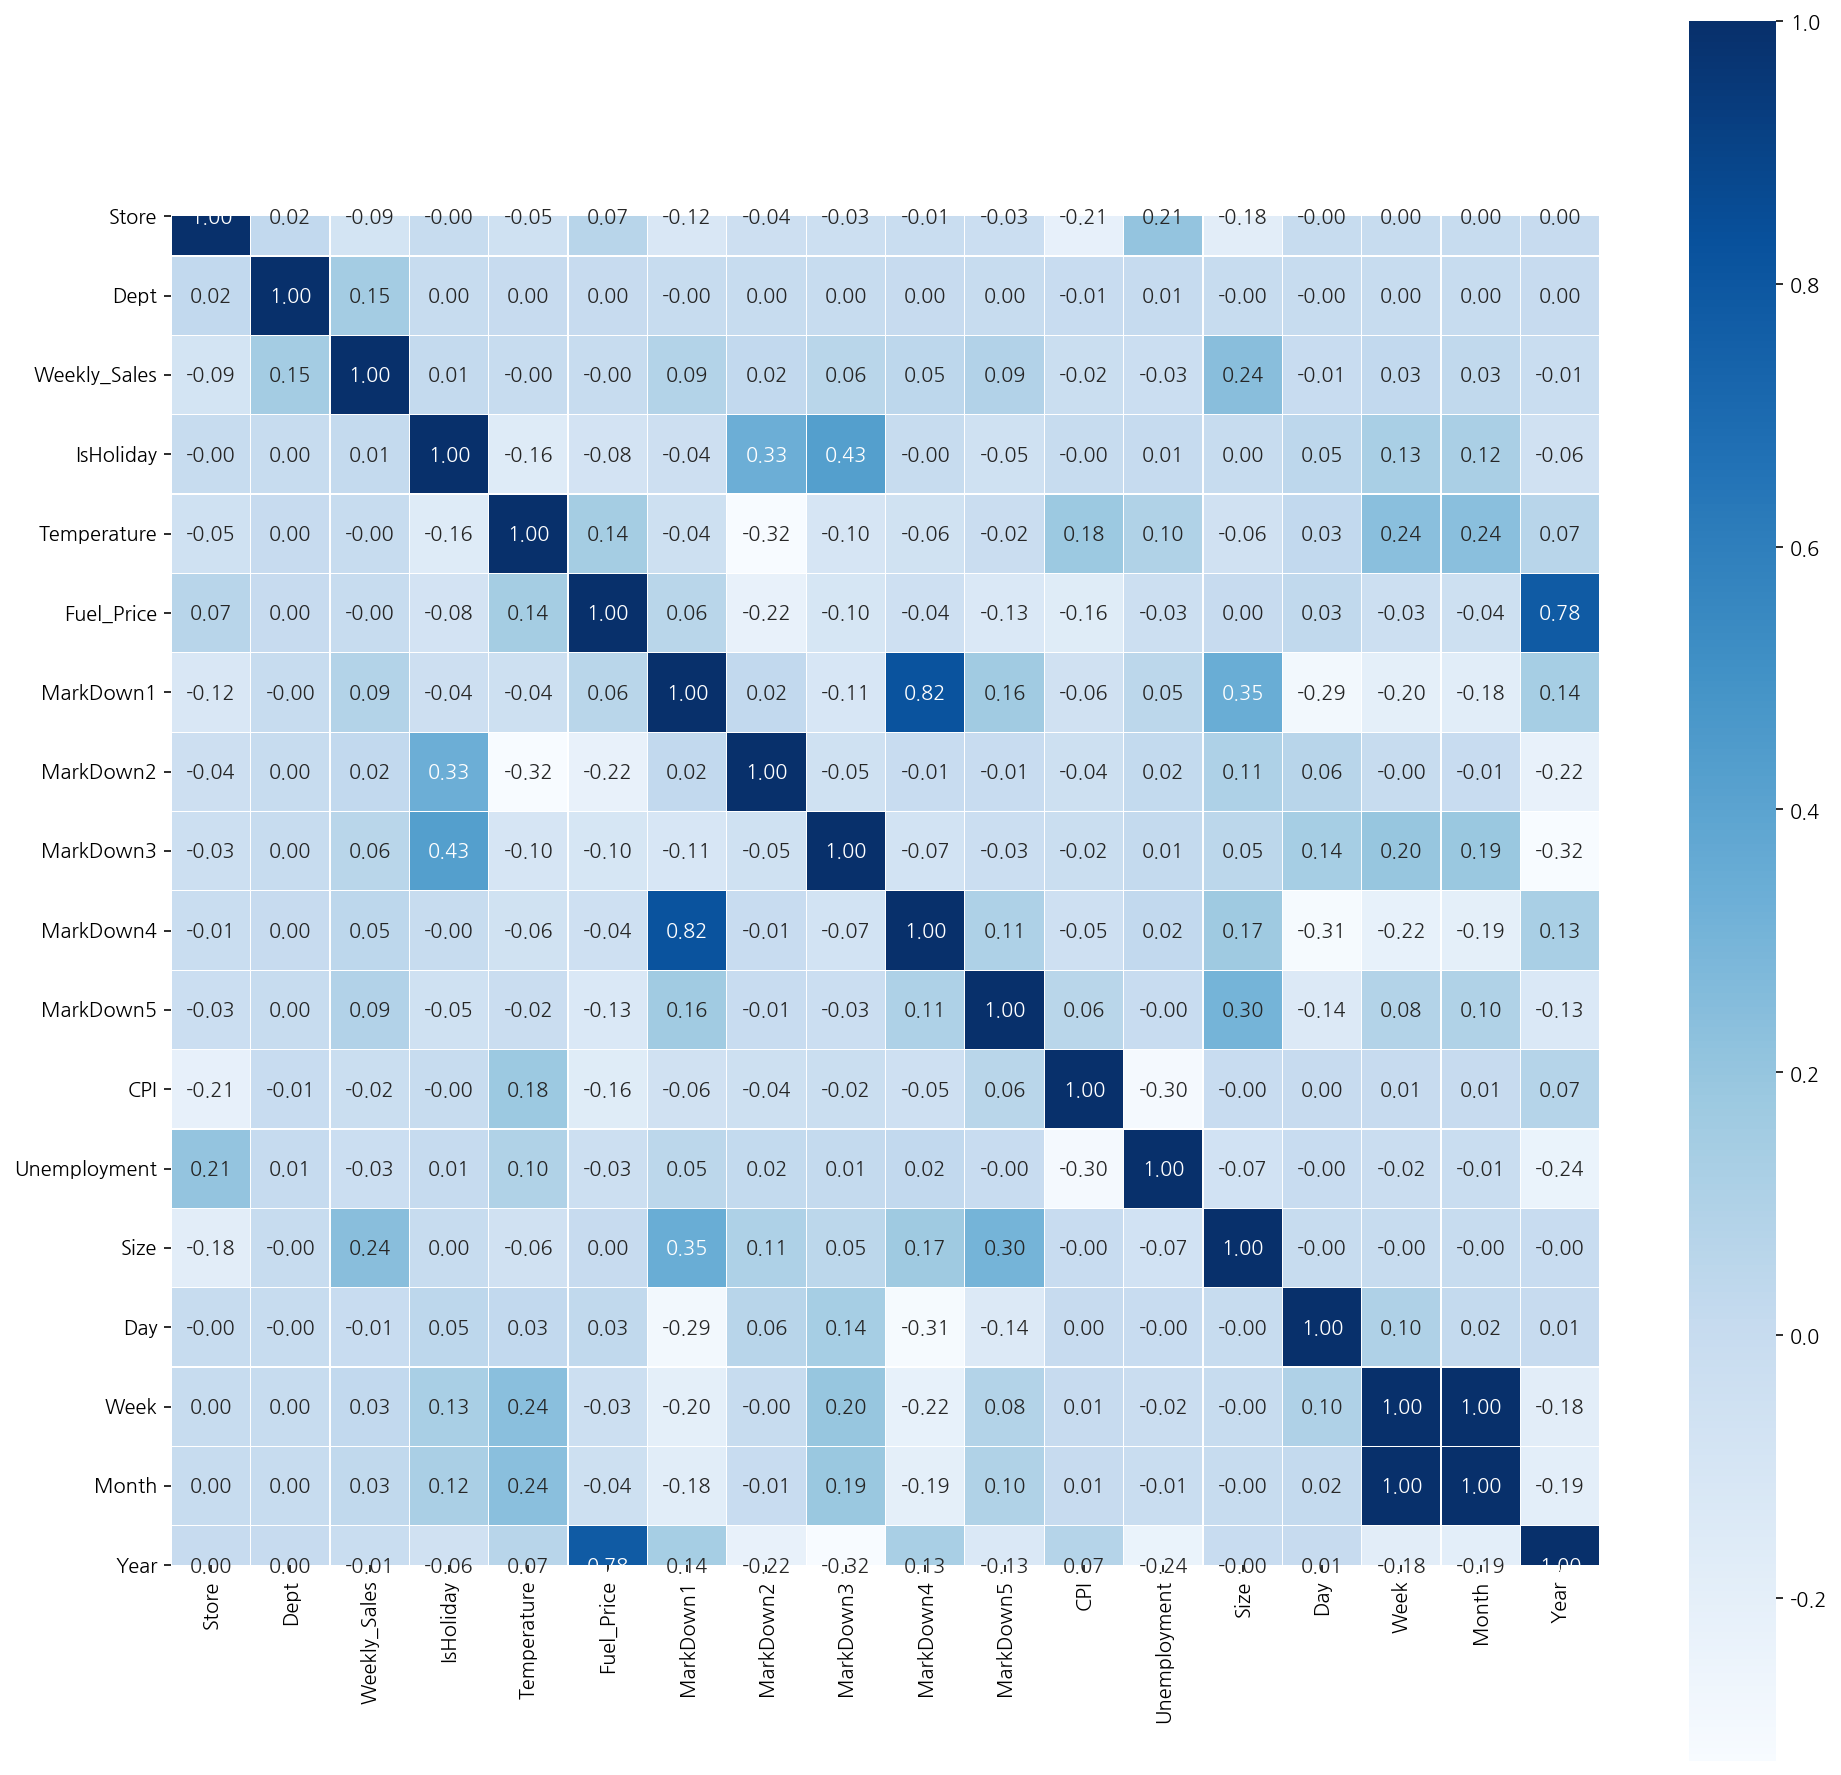

In [26]:
plt.figure(figsize=(16, 16))

sns.heatmap(train_df.corr(), 
            linewidths=0.1,
            square=True,
            annot=True,
            fmt='.2f',
            cmap='Blues')

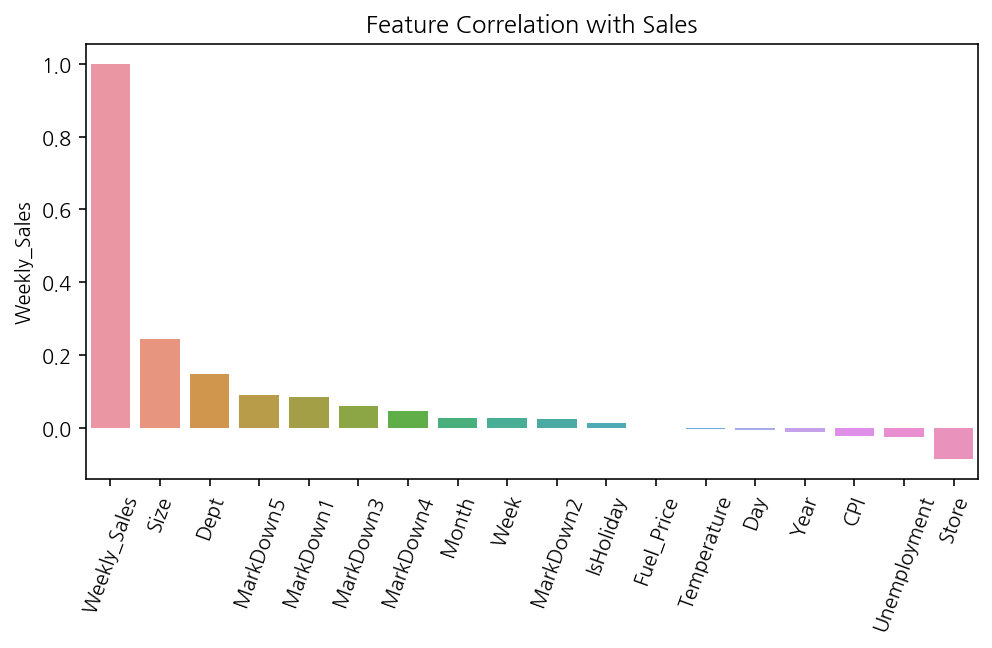

In [27]:
weekly_sales_corr = pd.DataFrame(train_df.corr()['Weekly_Sales']).sort_values(by='Weekly_Sales', ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(data=weekly_sales_corr, x=weekly_sales_corr.index, y='Weekly_Sales')
plt.xticks(rotation=70)
plt.title('Feature Correlation with Sales');

## Feature engineering

In [28]:
data_train = train_df.copy()
data_test = test_df.copy()

### Holidays

In [29]:
data_train['Days_to_Thanksgiving'] = (pd.to_datetime(train_df['Year'].astype(str)+"-11-24", format='%Y-%m-%d') - train_df['Date']).dt.days.astype(int)

data_train['Days_to_Christmas'] = (pd.to_datetime(train_df['Year'].astype(str)+"-12-24", format='%Y-%m-%d') - train_df['Date']).dt.days.astype(int)

In [30]:
data_test['Days_to_Thanksgiving'] = (pd.to_datetime(test_df['Year'].astype(str)+"-11-24", format='%Y-%m-%d') - test_df['Date']).dt.days.astype(int)

data_test['Days_to_Christmas'] = (pd.to_datetime(test_df['Year'].astype(str)+"-12-24", format='%Y-%m-%d') - test_df['Date']).dt.days.astype(int)

In [31]:
data_train['SuperBowlWeek'] = train_df['Week'].apply(lambda x : 1 if x == 6 else 0)
data_train['LaborDay'] = train_df['Week'].apply(lambda x : 1 if x == 36 else 0)
data_train['Thanksgiving'] = train_df['Week'].apply(lambda x : 1 if x == 47 else 0)
data_train['Christmas'] = train_df['Week'].apply(lambda x : 1 if x == 52 else 0)

In [32]:
data_test['SuperBowlWeek'] = test_df['Week'].apply(lambda x : 1 if x == 6 else 0)
data_test['LaborDay'] = test_df['Week'].apply(lambda x : 1 if x == 36 else 0)
data_test['Thanksgiving'] = test_df['Week'].apply(lambda x : 1 if x == 47 else 0)
data_test['Christmas'] = test_df['Week'].apply(lambda x : 1 if x == 52 else 0)

### Markdowns

In [33]:
data_train['MarkDownSum'] = train_df['MarkDown1'] + train_df['MarkDown2'] + train_df['MarkDown3'] + train_df['MarkDown4'] + train_df['MarkDown5']    
data_test['MarkDownSum'] = test_df['MarkDown1'] + test_df['MarkDown2'] + test_df['MarkDown3'] + test_df['MarkDown4'] + test_df['MarkDown5']    

## Preprocessing 

### missing values 

In [34]:
data_train.isna().sum()[data_train.isna().sum() > 0]

MarkDown1      270889
MarkDown2      310322
MarkDown3      284479
MarkDown4      286603
MarkDown5      270138
MarkDownSum    324514
dtype: int64

In [35]:
data_test.isna().sum()[data_test.isna().sum() > 0]

MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
CPI             38162
Unemployment    38162
MarkDownSum     37457
dtype: int64

In [36]:
data_train.fillna(0, inplace=True)

In [37]:
data_test['CPI'].fillna(data_test['CPI'].mean(), inplace=True)
data_test['Unemployment'].fillna(data_test['Unemployment'].mean(), inplace=True)

In [38]:
data_test.fillna(0, inplace=True)

### encoding categorical data

In [39]:
data_train['IsHoliday'] = data_train['IsHoliday'].apply(lambda x : 1 if x == True else 0)
data_test['IsHoliday'] = data_test['IsHoliday'].apply(lambda x : 1 if x == True else 0)

In [40]:
data_train['Type'] = data_train['Type'].apply(lambda x: 1 if x =='A' else (2 if x =='B' else 3))
data_test['Type'] = data_test['Type'].apply(lambda x: 1 if x =='A' else (2 if x =='B' else 3))

## Feature Selection

In [41]:
features = [feature for feature in data_train.columns if feature not in ('Date', 'Weekly_Sales') ]

In [ ]:
X = data_train[features].copy()
y = data_train.Weekly_Sales.copy()

In [42]:
data_sample = data_train.copy().sample(frac=.25)
X_sample = data_sample[features].copy()
y_sample = data_sample.Weekly_Sales.copy()

In [43]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_sample, y_sample, random_state=0, test_size=0.15)

In [44]:
feat_model = xgb.XGBRegressor(random_state=0, objective='reg:squarederror')
feat_model.fit(X_train, y_train)

XGBRegressor(objective='reg:squarederror')

In [45]:
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance 

perm = PermutationImportance(feat_model, random_state=1)
perm.fit(X_valid, y_valid)

feature_weights = eli5.show_weights(perm, top=len(X_train.columns), feature_names= X_valid.columns.tolist())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


* Permutation Importance는 모델을 학습시킨 뒤, 특정 feature의 데이터를 shuffle 했을 때, 검증 데이터 셋에 대한 예측성능을 확인하고 feature importance를 계산한다.

In [46]:
feature_weights

Weight,Feature
1.1548 ± 0.0174,Dept
0.3394 ± 0.0157,Size
0.0415 ± 0.0025,Store
0.0184 ± 0.0039,Thanksgiving
0.0098 ± 0.0008,CPI
0.0081 ± 0.0009,Week
0.0042 ± 0.0002,Type
0.0028 ± 0.0005,Days_to_Thanksgiving
0.0013 ± 0.0002,MarkDown3
0.0011 ± 0.0002,IsHoliday


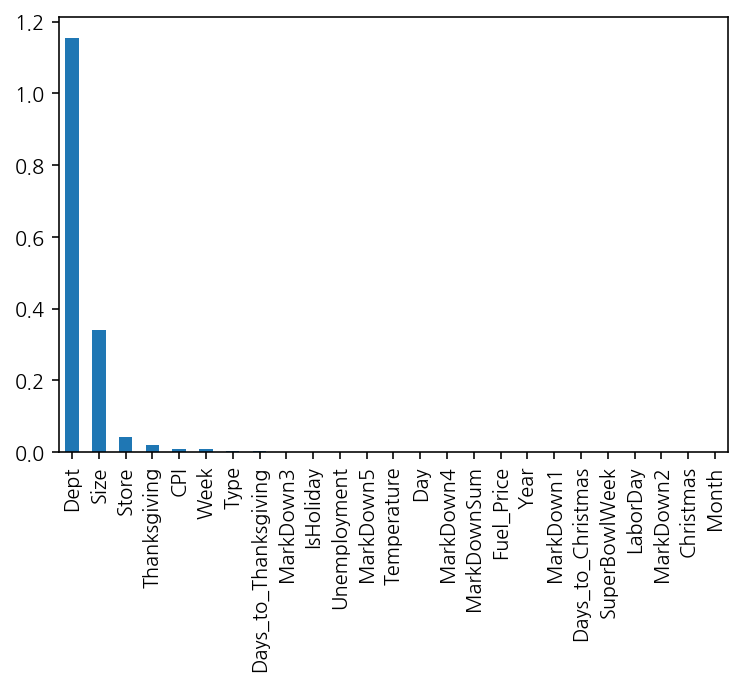

In [54]:
s = pd.Series(dict(zip(X_valid.columns.to_list(), perm.feature_importances_))).sort_values(ascending=False)
s.plot(kind='bar'); 

* Dept, Size, Store, CPI, Week는 Top 5 피처이다. 

## Modeling 

In [48]:
# Eval metric for the competition 
def WMAE(dataset, real, predict): 
  weights = datasets.IsHoliday.apply(lambda x : 5 if x else 1)
  return np.round(np.sum(weights*abs(real-predict))/np.sum(weights),2)

In [49]:
models = {
    'LGBM' : lgb.LGBMRegressor(random_state=0),
    'XGBoost' : xgb.XGBRegressor(random_state=0, objective ='reg:squarederror'), 
    'CatBoost' : cb.CatBoostRegressor(random_state=0, verbose=False), 
    'HGBR' : HistGradientBoostingRegressor(random_state=0), 
    'ExtraTr' : ensemble.ExtraTreesRegressor(bootstrap = True, random_state=0),
    'RandomF' : ensemble.RandomForestRegressor(random_state=0)
}

In [50]:
def model_evaluation (name, model, models, X_train, y_train, X_valid, y_valid): 

  rmses = []

  for i in range(len(models)): 

    # Model fit
    model.fit(X_train, y_train)
    
    # Model predict 
    y_preds = model.predict(X_valid)
    
    # RMSE 
    rmse = np.sqrt(np.mean( (y_valid-y_preds)**2))
    rmses.append(rmse) 
  
  return np.mean(rmses)

In [51]:
for name, model in models.items(): 
  result = model_evaluation(name, model, models, X_train, y_train, X_valid, y_valid)

  print(name + ' Valid RMSE : {:.4f}'.format(result))

LGBMValid RMSE : 6637.5050
XGBoostValid RMSE : 11147.8071
CatBoostValid RMSE : 5577.6563
HGBRValid RMSE : 6828.7690
ExtraTrValid RMSE : 4530.0808
RandomFValid RMSE : 4450.2748


### Baseline predictions 

In [68]:
X = data_train[features].copy()
y = data_train.Weekly_Sales.copy()

In [69]:
X_baseline = X[['Dept', 'Size','Store', 'Week', 'IsHoliday', 'Type', 'Year', 'Day']].copy()

In [70]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_baseline, y, random_state=0, test_size=0.1)

In [71]:
rf = ensemble.RandomForestRegressor(n_estimators=60,
                                    max_depth=25,
                                    min_samples_split=3,
                                    min_samples_leaf=1)

rf.fit(X_train.values, y_train.values)

RandomForestRegressor(max_depth=25, min_samples_split=3, n_estimators=60)

In [72]:
test = data_test[['Dept', 'Size','Store',  'Week', 'IsHoliday', 'Type', 'Year', 'Day']].copy()
predict_rf = rf.predict(test)

In [73]:
sample_submission['Weekly_Sales'] = predict_rf
sample_submission.to_csv('submission.csv', index=False)

In [76]:
# 2719 
58/688 * 100

8.430232558139535

### Simple Blend 

In [77]:
etr = ensemble.ExtraTreesRegressor(n_estimators=50, bootstrap=True, random_state=0) 
etr.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=True, n_estimators=50, random_state=0)

In [78]:
predict_etr = etr.predict(test)

In [81]:
avg_preds = (predict_rf + predict_etr) / 2 

In [80]:
sample_submission['Weekly_Sales'] = avg_preds 
sample_submission.to_csv('submission.csv', index=False)

In [82]:
#2672 
42/688 * 100

6.104651162790697